In [1]:
import mlrun
from dotenv import load_dotenv

### Create `project_setup.py`
Note: The context will be `src` so the paths are written with that in mind

In [2]:
%%writefile src/project_setup.py
import os

import mlrun


def setup(project: mlrun.projects.MlrunProject) -> mlrun.projects.MlrunProject:
    source = project.get_param("source")
    secrets_file = project.get_param("secrets_file")
    default_image = project.get_param("default_image")

    if source:
        print(f"Project Source: {source}")
        project.set_source(project.get_param("source"), pull_at_runtime=True)

    if secrets_file and os.path.exists(secrets_file):
        project.set_secrets(file_path=secrets_file)
        mlrun.set_env_from_file(secrets_file)

    if default_image:
        project.set_default_image(default_image)

    # MLRun Functions
    project.set_function(
        name="get-data",
        func="data.py",
        kind="job",
        handler="get_data",
    )

    project.set_function(
        name="train",
        func="train.py",
        kind="job",
        handler="train_model",
    )

    # MLRun Workflows
    project.set_workflow("main", "main_workflow.py")

    # Save and return the project:
    project.save()
    return project


Overwriting src/project_setup.py


### Load project

In [3]:
SOURCE = "https://github.com/mlrun/test-notebooks#main"
SECRETS_FILE = "mock_secrets.env"
DEFAULT_IMAGE = "mlrun/mlrun"

PARAMTERS = {
    "source" : SOURCE,
    "secrets_file" : SECRETS_FILE,
    "default_image" : DEFAULT_IMAGE
}

In [4]:
project = mlrun.get_or_create_project(name="test-project-setup", context="./src", parameters=PARAMTERS)

> 2023-11-09 18:23:45,763 [info] Loading project from path: {'project_name': 'test-project-setup', 'path': './src'}
Project Source: https://github.com/mlrun/test-notebooks#main
> 2023-11-09 18:24:02,226 [info] Project loaded successfully: {'project_name': 'test-project-setup', 'path': './src', 'stored_in_db': True}


### Check source

In [5]:
assert project.source == SOURCE

In [6]:
assert project.spec.load_source_on_run == True

### Check functions

In [7]:
assert len(project.spec.functions) == 2

In [8]:
functions = ["get-data", "train"]
functions_check = []

In [9]:
for f in project.spec.functions:
    functions_check.append(f["name"])

In [10]:
assert functions == functions_check

### Check workflows

In [11]:
assert len(project.spec.workflows) == 1

In [12]:
workflows = ["main"]
workflows_check = []

In [13]:
for w in project.spec.workflows:
    workflows_check.append(w["name"])

In [14]:
assert workflows == workflows_check

### Check params

In [15]:
assert project.spec.params == PARAMTERS

### Check project image

In [16]:
assert project.default_image == DEFAULT_IMAGE

### Check project secrets

In [17]:
# Get dict with secret file contents for comparison
secret_dict = dict(mlrun.set_env_from_file(SECRETS_FILE, return_dict=True))

In [18]:
# Cannot check secret contents but can check keys
db = mlrun.get_run_db()
secret_keys = db.list_project_secret_keys(project=project.metadata.name)

In [19]:
assert set(secret_keys.secret_keys) == set(secret_dict.keys())

### Run workflow

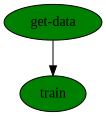

uid,start,state,name,parameters,results
...0ff46139,Nov 09 18:24:42,completed,train,label_column=labelmodel_name=modeltest_size=0.2random_state=42,accuracy=0.986f1_score=0.9860834990059643precision_score=0.9959839357429718recall_score=0.9763779527559056
...f9350802,Nov 09 18:24:11,completed,get-data,label_column=label,num_rows=2500


In [20]:
run_uid = project.run(
    name="main",
    arguments={
        "dataset" : "https://s3.wasabisys.com/iguazio/data/batch-predict/training_set.parquet",
        "label_column" : "label",
        "model_name" : "model",
        "test_size" : 0.2,
        "random_state" : 42
    },
    watch=True,
    dirty=True
)

### Check run outputs

In [21]:
workflow_runs = project.list_runs(labels=f"workflow={run_uid}").to_objects()

In [22]:
assert len(workflow_runs) == 2

In [23]:
DATA_OUTPUTS = ['num_rows', 'cleaned_data']
TRAIN_OUTPUTS = [
    'accuracy',
    'f1_score',
    'precision_score',
    'recall_score',
    'feature-importance',
    'test_set',
    'confusion-matrix',
    'roc-curves',
    'calibration-curve',
    'model'
]

In [24]:
for run in workflow_runs:
    assert run.metadata.name in ["get-data", "train"]
    if run.metadata.name == "get-data":
        assert list(run.outputs.keys()) == DATA_OUTPUTS
    elif run.metadata.name == "train":
        assert list(run.outputs.keys()) == TRAIN_OUTPUTS

### Clean up

In [25]:
db.delete_project(name=project.metadata.name, deletion_strategy="cascade")

> 2023-11-09 18:25:03,991 [info] Project is being deleted: {'project_name': 'test-project-setup'}
> 2023-11-09 18:25:07,292 [info] Project deleted: {'project_name': 'test-project-setup'}
